# Supervised Similarity Measure
https://colab.research.google.com/github/google/eng-edu/blob/main/ml/clustering/clustering-supervised-similarity.ipynb?utm_source=ss-clustering&utm_campaign=colab-external&utm_medium=referral&utm_content=clustering-supervised-similarity

We'll cluster chocolates in the [Chocolate Bar Ratings](https://www.kaggle.com/rtatman/chocolate-bar-ratings) dataset using k-means with a supervised similarity measure. The dataset has ratings
of chocolate bars along with their cocoa percentage, bean type, bean origin,
maker name, and maker country. You will:

* Load and clean the data.
* Process the data.
* Generate embeddings by training a DNN.
* Cluster the chocolates using k-means.
* Check the clustering result using quality metrics.



# 1. Load and clean data
Run the section below to load and clean the dataset. You do not need to understand the code. The code displays data for the first few chocolates.

In [1]:
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
from sklearn.preprocessing import OrdinalEncoder
from tqdm import tqdm
from IPython.display import clear_output, display

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [2]:
#@title Run to load and clean the dataset
# %reset -f
from __future__ import print_function

import math
import numpy as np
import numpy.linalg as nla
import pandas as pd
import re
import six
from os.path import join
from matplotlib import pyplot as plt

import tensorflow.compat.v1 as tf
from sklearn import metrics, preprocessing
tf.disable_v2_behavior()

from copy import deepcopy


# Set the output display to have one digit for decimal places and limit it to
# printing 15 rows.
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_rows = 15



choc_data = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/flavors_of_cacao.csv", sep=",", encoding='latin-1')

# We can rename the columns.
choc_data.columns = ['maker', 'specific_origin', 'reference_number', 'review_date', 'cocoa_percent', 'maker_location', 'rating', 'bean_type', 'broad_origin']

# choc_data.dtypes

# Replace empty/null values with "Blend"
choc_data['bean_type'] = choc_data['bean_type'].fillna('Blend')

#@title Cast bean_type to string to remove leading 'u'
choc_data['bean_type'] = choc_data['bean_type'].astype(str)
choc_data['cocoa_percent'] = choc_data['cocoa_percent'].str.strip('%')
choc_data['cocoa_percent'] = pd.to_numeric(choc_data['cocoa_percent'])

#@title Correct spelling mistakes, and replace city with country name
choc_data['maker_location'] = choc_data['maker_location']\
.str.replace('Amsterdam', 'Holland')\
.str.replace('U.K.', 'England')\
.str.replace('Niacragua', 'Nicaragua')\
.str.replace('Domincan Republic', 'Dominican Republic')

# Adding this so that Holland and Netherlands map to the same country.
choc_data['maker_location'] = choc_data['maker_location']\
.str.replace('Holland', 'Netherlands')

def cleanup_spelling_abbrev(text):
    replacements = [
        ['-', ', '], ['/ ', ', '], ['/', ', '], ['\(', ', '], [' and', ', '], [' &', ', '], ['\)', ''],
        ['Dom Rep|DR|Domin Rep|Dominican Rep,|Domincan Republic', 'Dominican Republic'],
        ['Mad,|Mad$', 'Madagascar, '],
        ['PNG', 'Papua New Guinea, '],
        ['Guat,|Guat$', 'Guatemala, '],
        ['Ven,|Ven$|Venez,|Venez$', 'Venezuela, '],
        ['Ecu,|Ecu$|Ecuad,|Ecuad$', 'Ecuador, '],
        ['Nic,|Nic$', 'Nicaragua, '],
        ['Cost Rica', 'Costa Rica'],
        ['Mex,|Mex$', 'Mexico, '],
        ['Jam,|Jam$', 'Jamaica, '],
        ['Haw,|Haw$', 'Hawaii, '],
        ['Gre,|Gre$', 'Grenada, '],
        ['Tri,|Tri$', 'Trinidad, '],
        ['C Am', 'Central America'],
        ['S America', 'South America'],
        [', $', ''], [',  ', ', '], [', ,', ', '], ['\xa0', ' '],[',\s+', ','],
        [' Bali', ',Bali']
    ]
    for i, j in replacements:
        text = re.sub(i, j, text)
    return text

choc_data['specific_origin'] = choc_data['specific_origin'].str.replace('.', '').apply(cleanup_spelling_abbrev)

#@title Cast specific_origin to string
choc_data['specific_origin'] = choc_data['specific_origin'].astype(str)

#@title Replace null-valued fields with the same value as for specific_origin
choc_data['broad_origin'] = choc_data['broad_origin'].fillna(choc_data['specific_origin'])

#@title Clean up spelling mistakes and deal with abbreviations
choc_data['broad_origin'] = choc_data['broad_origin'].str.replace('.', '').apply(cleanup_spelling_abbrev)

# Change 'Trinitario, Criollo' to "Criollo, Trinitario"
# Check with choc_data['bean_type'].unique()
choc_data.loc[choc_data['bean_type'].isin(['Trinitario, Criollo']),'bean_type'] = "Criollo, Trinitario"
# Confirm with choc_data[choc_data['bean_type'].isin(['Trinitario, Criollo'])]

# Fix chocolate maker names
choc_data.loc[choc_data['maker']=='Shattel','maker'] = 'Shattell'
choc_data['maker'] = choc_data['maker'].str.replace(u'Na\xef\xbf\xbdve','Naive')

# Save the original column names
original_cols = choc_data.columns.values

orign_choc_data = deepcopy(choc_data)
choc_data.head()

Instructions for updating:
non-resource variables are not supported in the long term


,maker,specific_origin,reference_number,review_date,cocoa_percent,maker_location,rating,bean_type,broad_origin
0,A. Morin,Agua Grande,1876,2016,63.00,France,3.75,Blend,Sao Tome
1,A. Morin,Kpime,1676,2015,70.00,France,2.75,Blend,Togo
2,A. Morin,Atsane,1676,2015,70.00,France,3.00,Blend,Togo
3,A. Morin,Akata,1680,2015,70.00,France,3.50,Blend,Togo
4,A. Morin,Quilla,1704,2015,70.00,France,3.50,Blend,Peru


# 2. Process Data
Because you're using a DNN, you do not need to manually process the data. The DNN transforms the data for us. However, if possible, you should remove features that could distort the similarity calculation. Here, the features `review_date` and `reference_number` are not correlated with similarity. That is, chocolates that are reviewed closer together in time are not more or less similar than chocolates reviewed further apart. Remove these two features by running the following code.

In [3]:
# choc_data.drop(columns=['review_date','reference_number'],inplace=True)
choc_data.head()

,maker,specific_origin,reference_number,review_date,cocoa_percent,maker_location,rating,bean_type,broad_origin
0,A. Morin,Agua Grande,1876,2016,63.00,France,3.75,Blend,Sao Tome
1,A. Morin,Kpime,1676,2015,70.00,France,2.75,Blend,Togo
2,A. Morin,Atsane,1676,2015,70.00,France,3.00,Blend,Togo
3,A. Morin,Akata,1680,2015,70.00,France,3.50,Blend,Togo
4,A. Morin,Quilla,1704,2015,70.00,France,3.50,Blend,Peru


In [4]:
# choc_data['rating_norm'] = (choc_data['rating'] - choc_data['rating'].mean()
#                            ) / choc_data['rating'].std()

# choc_data['rating_out'] = choc_data['rating']

# choc_data['cocoa_percent_norm'] = (
#     choc_data['cocoa_percent'] -
#     choc_data['cocoa_percent'].mean()) / choc_data['cocoa_percent'].std()

In [5]:
# original_cols

In [6]:
# # duplicate the "maker" feature since it's removed by one-hot encoding function
# choc_data['maker2'] = choc_data['maker']
# choc_data = pd.get_dummies(choc_data, columns=['maker2'], prefix=['maker'])
# # similarly, duplicate the "bean_type" feature
# choc_data['bean_type2'] = choc_data['bean_type']
# choc_data = pd.get_dummies(choc_data, columns=['bean_type2'], prefix=['bean'])

# # Split dataframe into two frames: Original data and data for clustering
# choc_data_backup = choc_data.loc[:, original_cols].copy(deep=True)
# choc_data.drop(columns=original_cols, inplace=True)

# # get_dummies returned ints for one-hot encoding but we want floats so divide by
# # 1.0
# # Note: In the latest version of "get_dummies", you can set "dtype" to float
# choc_data = choc_data / 1.0

In [7]:
choc_data.drop(columns=['review_date','reference_number'],inplace=True)
choc_data.head()

,maker,specific_origin,cocoa_percent,maker_location,rating,bean_type,broad_origin
0,A. Morin,Agua Grande,63.00,France,3.75,Blend,Sao Tome
1,A. Morin,Kpime,70.00,France,2.75,Blend,Togo
2,A. Morin,Atsane,70.00,France,3.00,Blend,Togo
3,A. Morin,Akata,70.00,France,3.50,Blend,Togo
4,A. Morin,Quilla,70.00,France,3.50,Blend,Peru


In [8]:
categorical = ['maker', 'specific_origin', 'maker_location', 'bean_type', 'broad_origin']
for feat in tqdm(categorical):
#     lbl_enc = preprocessing.LabelEncoder()
    
#     choc_data[feat] = lbl_enc.fit_transform(choc_data[feat]. \
#                                          fillna('-1'). \
#                                          astype(str).values)
    choc_data = pd.get_dummies(choc_data, columns=[feat], prefix=['OneHot'])
    print(feat in set(choc_data.columns))

100%|██████████| 5/5 [00:00<00:00, 116.89it/s]

False
False
False
False
False


In [9]:
# choc_data.drop(columns=['review_date','reference_number'],inplace=True)
choc_data[list(choc_data.columns)].head()
choc_data = choc_data.loc[:,~choc_data.columns.duplicated()].copy()

print(choc_data.shape)
choc_data.head()

(1795, 1566)


,cocoa_percent,rating,OneHot_A. Morin,OneHot_AMMA,OneHot_Acalli,OneHot_Adi,OneHot_Aequare (Gianduja),OneHot_Ah Cacao,OneHot_Akesson's (Pralus),OneHot_Alain Ducasse,...,"OneHot_Venezuela,Africa,Brasil,Peru,Mexico","OneHot_Venezuela,Bolivia,Dominican Republic","OneHot_Venezuela,Carribean","OneHot_Venezuela,Dominican Republic","OneHot_Venezuela,Ecuador,Peru,Nicaragua","OneHot_Venezuela,Ghana","OneHot_Venezuela,Indonesia,Ecuador","OneHot_Venezuela,Java","OneHot_Venezuela,Trinidad,Ecuador","OneHot_Venezuela,Trinidad,Madagascar"
0,63.00,3.75,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,70.00,2.75,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,70.00,3.00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,70.00,3.50,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,70.00,3.50,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
choc_data[list(choc_data.columns)].head()

,cocoa_percent,rating,OneHot_A. Morin,OneHot_AMMA,OneHot_Acalli,OneHot_Adi,OneHot_Aequare (Gianduja),OneHot_Ah Cacao,OneHot_Akesson's (Pralus),OneHot_Alain Ducasse,...,"OneHot_Venezuela,Africa,Brasil,Peru,Mexico","OneHot_Venezuela,Bolivia,Dominican Republic","OneHot_Venezuela,Carribean","OneHot_Venezuela,Dominican Republic","OneHot_Venezuela,Ecuador,Peru,Nicaragua","OneHot_Venezuela,Ghana","OneHot_Venezuela,Indonesia,Ecuador","OneHot_Venezuela,Java","OneHot_Venezuela,Trinidad,Ecuador","OneHot_Venezuela,Trinidad,Madagascar"
0,63.00,3.75,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,70.00,2.75,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,70.00,3.00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,70.00,3.50,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,70.00,3.50,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
# len(choc_data[[col for col in choc_data.columns if col != 'rating' ]].columns) 

len(choc_data.columns)

1566

In [12]:
from sklearn.model_selection import train_test_split

# Map features and labels into a tensor dataset
class LocationDataset(Dataset):
    def __init__(self, df, x_name, y_name):
        self.x = torch.tensor(df[x_name].to_numpy().reshape(-1, len(x_name))).float()
        self.y = torch.tensor(df[y_name].to_numpy().reshape(-1, 1)).float()
    
    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])
    
    def __len__(self):
        return len(self.y)
    
    
# Shuffle the training set
choc_data = (choc_data
             .sample(frac=1, random_state=42)
             .reset_index(drop=True))   

dat = LocationDataset(choc_data, [col for col in choc_data.columns if col != 'rating' ], 'rating')

# 3. Generate Embeddings from DNN

We're ready to generate embeddings by training the DNN on the feature data. This section draws on concepts discussed on the page [Supervised Similarity Measure](https://developers.google.com/machine-learning/clustering/similarity/supervised-similarity).

Run the section below to set up functions to train the DNN that generates embeddings. You do not need to understand the code.

The next cell trains the DNN. You can choose either a predictor DNN or an autoencoder DNN by specifying the parameter `output_feature_names` as follows:

* If choosing a predictor DNN, specify one feature, for example, [`rating`].
* If choosing an autoencoder DNN, specify all features as follows: `['maker','maker_location','broad_origin','cocoa_percent','bean_type','rating']`.

You do not need to change the other parameters, but if you're curious:
* `l2_regularization`: Controls the weight for L2 regularization.
* `hidden_dims`: Controls the dimensions of the hidden layers.

Running the next cell generates the following plots:

* '*total*': Total loss across all features.
* '*feature*': Loss for the specified output features.
* '*embeddings*': First two dimensions of the generated embeddings.

In [13]:
# Define the model
class LinearRegressionModel(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.linear = nn.Sequential(
                nn.Linear(num_features, 20),
                nn.Linear(20, 10)
            )
        
    def forward(self, x):
        y_hat = self.linear(x)
        return y_hat
    
model = LinearRegressionModel(choc_data.shape[1]-1).to(device)    
model

LinearRegressionModel(
  (linear): Sequential(
    (0): Linear(in_features=1565, out_features=20, bias=True)
    (1): Linear(in_features=20, out_features=10, bias=True)
  )
)

In [14]:
#@title Training a DNN Similarity Model

# Define some constants related to this dataset.
sparse_feature_names = ('maker', 'maker_location', 'broad_origin',
                        'specific_origin', 'bean_type')
dense_feature_names = ('reference_number', 'review_date', 'cocoa_percent',
                       'rating')

# Set of features used as input to the similarity model.
input_feature_names = ('maker', 'maker_location', 'broad_origin',
                       'cocoa_percent', 'bean_type','rating', )
# Set of features used as output to the similarity model.
output_feature_names = ['rating']  #@param

# Weight of the L2 regularization applied to the top embedding layer.
l2_regularization = 10  #@param
# List of dimensions of the hidden layers of the deep neural network.
hidden_dims = [20, 10]  #@param

batch_size=100
use_bias=True
num_iterations=10000
learning_rate=0.1
optimizer=tf.train.AdagradOptimizer

print("input_feature_names: ", input_feature_names)
print("output_feature_names: ", output_feature_names)
print("dense_feature_names: ", dense_feature_names)
# print("sparse_input_feature_embedding_dims: ", sparse_input_feature_embedding_dims)
print("hidden_dims: ", hidden_dims)
print("l2_regularization: ", l2_regularization)
print("batch_size: ", batch_size)
print("use_bias: ", use_bias)

print("num_iterations: ", num_iterations)
print("learning_rate: ", learning_rate)
print("optimizer: ", optimizer)

print('------ build model')

input_feature_names:  ('maker', 'maker_location', 'broad_origin', 'cocoa_percent', 'bean_type', 'rating')
output_feature_names:  ['rating']
dense_feature_names:  ('reference_number', 'review_date', 'cocoa_percent', 'rating')
hidden_dims:  [20, 10]
l2_regularization:  10
batch_size:  100
use_bias:  True
num_iterations:  10000
learning_rate:  0.1
optimizer:  <class 'tensorflow.python.training.adagrad.AdagradOptimizer'>
------ build model


In [15]:
class similarity_loss(nn.Module):
    def __init__(self):
        super(similarity_loss, self).__init__()       
        self.mse = nn.MSELoss()
    
    def forward(self, y_hat, y):    
        
        total_loss = torch.mul(torch.sum(torch.square(y_hat)) , l2_regularization)
        losses_fn = self.mse(y_hat, y) 
        return (total_loss + losses_fn) , losses_fn
    
criterion = similarity_loss()
criterion

similarity_loss(
  (mse): MSELoss()
)

In [16]:
import math
from barbar import Bar

# Hyperparameters
# learning_rate = 0.05
epochs = 30
batch_size = 100
# batch_size = 5

# For now we use the entire dataset for training (no validation set)
torch.manual_seed(42)
model = None
model = LinearRegressionModel(choc_data.shape[1]-1).to(device)   

criterion = similarity_loss()
optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate, 
                                lr_decay=0, weight_decay=0, initial_accumulator_value=0)


train_ds, valid_ds = train_test_split(dat, test_size=0.1)
train_loader=DataLoader(train_ds,batch_size=batch_size,shuffle=False)
valid_loader=DataLoader(valid_ds,batch_size=batch_size,shuffle=False)

losses = []

epoch_train_loss = []
epoch_valid_loss = []

epoch_train_loss_fn = []
epoch_valid_loss_fn = []

for epoch in range(epochs):
    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_loss_fn = []    
    
    for x_batch, y_batch in Bar(train_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        y_hat = model(x_batch)
    
        loss, losses_fn = criterion(y_hat, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()  
        
        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_loss_fn.append(losses_fn.item())
        
    train_loss = sum(train_loss) / len(train_loss)
    train_loss_fn = sum(train_loss_fn) / len(train_loss_fn)    
    
    epoch_train_loss.append(train_loss)
    epoch_train_loss_fn.append(train_loss_fn)
    
    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()
    
    # These are used to record information in validation.
    valid_loss = []
    valid_loss_fn = []
   
    
    # Iterate the validation set by batches.    
    for x_batch, y_batch in Bar(valid_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        y_hat = model(x_batch)
    
        loss, losses_fn = criterion(y_hat, y_batch)
        
        # Record the loss and accuracy.
        # losses.append(loss.item())
        valid_loss.append(loss.item())
        valid_loss_fn.append(losses_fn.item())
        
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_loss_fn = sum(valid_loss_fn) / len(valid_loss_fn) 
    
    epoch_valid_loss.append(valid_loss)
    epoch_valid_loss_fn.append(valid_loss_fn)               

    
    display(f"[ Epoch | {epoch + 1:03d}/{epochs:03d} ] \
          train_loss = {train_loss:.5f} feature train rating loss = {train_loss_fn:.5f}| \
          valid_loss = {valid_loss:.5f} feature valid rating loss = {valid_loss_fn:.5f}")

1615/1615: [==============================>.] - ETA 0.0s
180/180: [================>...............] - ETA 0.0s


/home/leyan/anaconda3/envs/tensorflow/lib/python3.6/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([100, 1])) that is different to the input size (torch.Size([100, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/leyan/anaconda3/envs/tensorflow/lib/python3.6/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([15, 1])) that is different to the input size (torch.Size([15, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/leyan/anaconda3/envs/tensorflow/lib/python3.6/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([80, 1])) that is different to the input size (torch.Size([80, 10])). This will likely lead to incorrect re

'[ Epoch | 001/030 ]           train_loss = 98835.63511 feature train rating loss = 20.26100|           valid_loss = 78.62353 feature valid rating loss = 10.49930'

1615/1615: [==============================>.] - ETA 0.0s
180/180: [================>...............] - ETA 0.0s


'[ Epoch | 002/030 ]           train_loss = 199.83992 feature train rating loss = 10.35708|           valid_loss = 62.36059 feature valid rating loss = 10.48344'

1615/1615: [==============================>.] - ETA 0.0s
180/180: [================>...............] - ETA 0.0s


'[ Epoch | 003/030 ]           train_loss = 124.81329 feature train rating loss = 10.34448|           valid_loss = 53.74308 feature valid rating loss = 10.44021'

1615/1615: [==============================>.] - ETA 0.0s
180/180: [================>...............] - ETA 0.0s


'[ Epoch | 004/030 ]           train_loss = 93.03880 feature train rating loss = 10.34286|           valid_loss = 45.84605 feature valid rating loss = 10.48170'

1615/1615: [==============================>.] - ETA 0.0s
180/180: [================>...............] - ETA 0.0s


'[ Epoch | 005/030 ]           train_loss = 75.82801 feature train rating loss = 10.33883|           valid_loss = 41.59286 feature valid rating loss = 10.46356'

1615/1615: [==============================>.] - ETA 0.0s
180/180: [================>...............] - ETA 0.0s


'[ Epoch | 006/030 ]           train_loss = 64.87675 feature train rating loss = 10.34009|           valid_loss = 38.53871 feature valid rating loss = 10.45313'

1615/1615: [==============================>.] - ETA 0.0s
180/180: [================>...............] - ETA 0.0s


'[ Epoch | 007/030 ]           train_loss = 56.84855 feature train rating loss = 10.33800|           valid_loss = 37.87135 feature valid rating loss = 10.52887'

1615/1615: [==============================>.] - ETA 0.0s
180/180: [================>...............] - ETA 0.0s


'[ Epoch | 008/030 ]           train_loss = 49.47785 feature train rating loss = 10.33474|           valid_loss = 39.37659 feature valid rating loss = 10.39404'

1615/1615: [==============================>.] - ETA 0.0s
180/180: [================>...............] - ETA 0.0s


'[ Epoch | 009/030 ]           train_loss = 43.41804 feature train rating loss = 10.33820|           valid_loss = 31.02050 feature valid rating loss = 10.46664'

1615/1615: [==============================>.] - ETA 0.0s
180/180: [================>...............] - ETA 0.0s


'[ Epoch | 010/030 ]           train_loss = 39.28269 feature train rating loss = 10.33426|           valid_loss = 30.02623 feature valid rating loss = 10.45631'

1615/1615: [==============================>.] - ETA 0.0s
180/180: [================>...............] - ETA 0.0s


'[ Epoch | 011/030 ]           train_loss = 35.94954 feature train rating loss = 10.33585|           valid_loss = 28.50196 feature valid rating loss = 10.45700'

1615/1615: [==============================>.] - ETA 0.0s
180/180: [================>...............] - ETA 0.0s


'[ Epoch | 012/030 ]           train_loss = 33.42660 feature train rating loss = 10.33475|           valid_loss = 27.62816 feature valid rating loss = 10.45113'

1615/1615: [==============================>.] - ETA 0.0s
180/180: [================>...............] - ETA 0.0s


'[ Epoch | 013/030 ]           train_loss = 31.24527 feature train rating loss = 10.33486|           valid_loss = 26.52440 feature valid rating loss = 10.45222'

1615/1615: [==============================>.] - ETA 0.0s
180/180: [================>...............] - ETA 0.0s


'[ Epoch | 014/030 ]           train_loss = 29.37733 feature train rating loss = 10.33450|           valid_loss = 25.77240 feature valid rating loss = 10.44992'

1615/1615: [==============================>.] - ETA 0.0s
180/180: [================>...............] - ETA 0.0s


'[ Epoch | 015/030 ]           train_loss = 27.73919 feature train rating loss = 10.33444|           valid_loss = 24.95819 feature valid rating loss = 10.45011'

1615/1615: [==============================>.] - ETA 0.0s
180/180: [================>...............] - ETA 0.0s


'[ Epoch | 016/030 ]           train_loss = 26.30358 feature train rating loss = 10.33426|           valid_loss = 24.29296 feature valid rating loss = 10.44912'

1615/1615: [==============================>.] - ETA 0.0s
180/180: [================>...............] - ETA 0.0s


'[ Epoch | 017/030 ]           train_loss = 25.03253 feature train rating loss = 10.33418|           valid_loss = 23.68226 feature valid rating loss = 10.44859'

1615/1615: [==============================>.] - ETA 0.0s
180/180: [================>...............] - ETA 0.0s


'[ Epoch | 018/030 ]           train_loss = 23.90467 feature train rating loss = 10.33407|           valid_loss = 23.14491 feature valid rating loss = 10.44783'

1615/1615: [==============================>.] - ETA 0.0s
180/180: [================>...............] - ETA 0.0s


'[ Epoch | 019/030 ]           train_loss = 22.89822 feature train rating loss = 10.33399|           valid_loss = 22.64605 feature valid rating loss = 10.44727'

1615/1615: [==============================>.] - ETA 0.0s
180/180: [================>...............] - ETA 0.0s


'[ Epoch | 020/030 ]           train_loss = 21.99678 feature train rating loss = 10.33391|           valid_loss = 22.20141 feature valid rating loss = 10.44671'

1615/1615: [==============================>.] - ETA 0.0s
180/180: [================>...............] - ETA 0.0s


'[ Epoch | 021/030 ]           train_loss = 21.18652 feature train rating loss = 10.33385|           valid_loss = 21.79504 feature valid rating loss = 10.44619'

1615/1615: [==============================>.] - ETA 0.0s
180/180: [================>...............] - ETA 0.0s


'[ Epoch | 022/030 ]           train_loss = 20.45575 feature train rating loss = 10.33379|           valid_loss = 21.42352 feature valid rating loss = 10.44571'

1615/1615: [==============================>.] - ETA 0.0s
180/180: [================>...............] - ETA 0.0s


'[ Epoch | 023/030 ]           train_loss = 19.79464 feature train rating loss = 10.33373|           valid_loss = 21.08375 feature valid rating loss = 10.44526'

1615/1615: [==============================>.] - ETA 0.0s
180/180: [================>...............] - ETA 0.0s


'[ Epoch | 024/030 ]           train_loss = 19.19483 feature train rating loss = 10.33368|           valid_loss = 20.77399 feature valid rating loss = 10.44482'

1615/1615: [==============================>.] - ETA 0.0s
180/180: [================>...............] - ETA 0.0s


'[ Epoch | 025/030 ]           train_loss = 18.64919 feature train rating loss = 10.33364|           valid_loss = 20.48803 feature valid rating loss = 10.44441'

1615/1615: [==============================>.] - ETA 0.0s
180/180: [================>...............] - ETA 0.0s


'[ Epoch | 026/030 ]           train_loss = 18.15156 feature train rating loss = 10.33360|           valid_loss = 20.22549 feature valid rating loss = 10.44401'

1615/1615: [==============================>.] - ETA 0.0s
180/180: [================>...............] - ETA 0.0s


'[ Epoch | 027/030 ]           train_loss = 17.69662 feature train rating loss = 10.33356|           valid_loss = 19.98343 feature valid rating loss = 10.44362'

1615/1615: [==============================>.] - ETA 0.0s
180/180: [================>...............] - ETA 0.0s


'[ Epoch | 028/030 ]           train_loss = 17.27978 feature train rating loss = 10.33353|           valid_loss = 19.75959 feature valid rating loss = 10.44324'

1615/1615: [==============================>.] - ETA 0.0s
180/180: [================>...............] - ETA 0.0s


'[ Epoch | 029/030 ]           train_loss = 16.89700 feature train rating loss = 10.33350|           valid_loss = 19.55227 feature valid rating loss = 10.44288'

1615/1615: [==============================>.] - ETA 0.0s
180/180: [================>...............] - ETA 0.0s


'[ Epoch | 030/030 ]           train_loss = 16.54477 feature train rating loss = 10.33347|           valid_loss = 19.36006 feature valid rating loss = 10.44252'

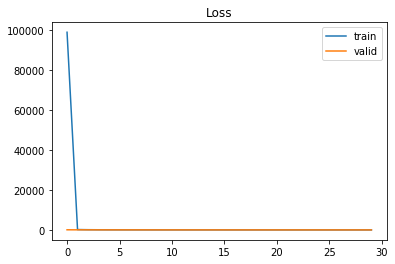

In [17]:
# Loss curve
plt.plot(epoch_train_loss)
plt.plot(epoch_valid_loss)
plt.title('Loss')
plt.legend(['train', 'valid'])
plt.savefig('loss.png')
plt.show()

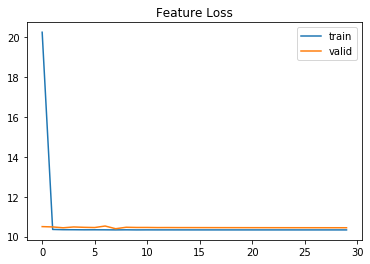

In [18]:
# Loss curve
plt.plot(epoch_train_loss_fn)
plt.plot(epoch_valid_loss_fn)
plt.title('Feature Loss')
plt.legend(['train', 'valid'])
plt.savefig('Feature loss.png')
plt.show()

# 4. Cluster Chocolate Dataset
We're ready to cluster the chocolates! Run the code to set up the k-means clustering functions. You do not need to understand the code.

**Note**: If you're following the Clustering self study, then before running the rest of this Colab, read the sections on [k-means](https://developers.google.com/machine-learning/clustering/algorithm/run-algorithm) and [quality metrics](https://developers.google.com/machine-learning/clustering/interpret).

In [19]:
#@title Run cell to set up functions
def dfSimilarity(df,centroids):
  ### dfSimilarity = Calculate similarities for dataframe input
  ### We need to calculate ||a-b||^2 = |a|^2 + |b|^2 - 2*|a|*|b|
  ### Implement this with matrix operations
  ### See the Appendix for further explanation
  numPoints = len(df.index)
  numCentroids = len(centroids.index)
  ## Strictly speaking, we don't need to calculate the norm of points
  # because it adds a constant bias to distances
  # But calculating it so that the similarity doesn't go negative
  # And that we expect similarities in [0,1] which aids debugging
  pointNorms = np.square(nla.norm(df,axis=1))
  pointNorms = np.reshape(pointNorms,[numPoints,1])
  ## Calculate the norm of centroids
  centroidNorms = np.square(nla.norm(centroids,axis=1))
  centroidNorms = np.reshape(centroidNorms,(1,numCentroids))
  ## Calculate |a|^2 + |b|^2 - 2*|a|*|b|
  similarities = pointNorms + centroidNorms - 2.0*np.dot(df,np.transpose(centroids))
  # Divide by the number of features
  # Which is 10 because the one-hot encoding means the "Maker" and "Bean" are
  # weighted twice
  similarities = similarities/10.0
  # numerical artifacts lead to negligible but negative values that go to NaN on the root
  similarities = similarities.clip(min=0.0)
  # Square root since it's ||a-b||^2
  similarities = np.sqrt(similarities)
  return similarities

def initCentroids(df,k,feature_cols):
  # Pick 'k' examples are random to serve as initial centroids
  limit = len(df.index)
  centroids_key = np.random.randint(0,limit-1,k)
  centroids = df.loc[centroids_key,feature_cols].copy(deep=True)
  # the indexes get copied over so reset them
  centroids.reset_index(drop=True,inplace=True)
  return centroids

def pt2centroid(df,centroids,feature_cols):
  ### Calculate similarities between all points and centroids
  ### And assign points to the closest centroid + save that distance
  numCentroids = len(centroids.index)
  numExamples = len(df.index)
  # dfSimilarity = Calculate similarities for dataframe input
  dist = dfSimilarity(df.loc[:,feature_cols],centroids.loc[:,feature_cols])
  df.loc[:,'centroid'] = np.argmin(dist,axis=1) # closest centroid
  df.loc[:,'pt2centroid'] = np.min(dist,axis=1) # minimum distance
  return df

def recomputeCentroids(df,centroids,feature_cols):
  ### For every centroid, recompute it as an average of the points
  ### assigned to it
  numCentroids = len(centroids.index)
  for cen in range(numCentroids):
    dfSubset = df.loc[df['centroid'] == cen, feature_cols] # all points for centroid
    if not(dfSubset.empty): # if there are points assigned to the centroid
      clusterAvg = np.sum(dfSubset)/len(dfSubset.index)
      centroids.loc[cen] = clusterAvg
  return centroids

def kmeans(df,k,feature_cols,verbose):
  flagConvergence = False
  maxIter = 100
  iter = 0                      # ensure kmeans doesn't run for ever
  centroids = initCentroids(df,k,feature_cols)
  while not(flagConvergence):
    iter += 1
    #Save old mapping of points to centroids
    oldMapping = df['centroid'].copy(deep=True)
    # Perform k-means
    df = pt2centroid(df,centroids,feature_cols)
    centroids = recomputeCentroids(df,centroids,feature_cols)
    # Check convergence by comparing [oldMapping, newMapping]
    newMapping = df['centroid']
    flagConvergence = all(oldMapping == newMapping)
    if verbose == 1:
      print("Total distance:" + str(np.sum(df['pt2centroid'])))
    if (iter > maxIter):
      print('k-means did not converge! Reached maximum iteration limit of ' \
            + str(maxIter) + '.')
      sys.exit()
      return
  print('k-means converged for ' + str(k) + ' clusters' + \
        ' after ' + str(iter) + ' iterations!')
  return [df,centroids]

Run the following cell to cluster the chocolate dataset, where `k` is the number of clusters. You'll experiment with different values of `k` later. For now, use `k = 160`.

On every iteration of k-means, the output shows how the sum of distances from all examples to their centroids reduces, such that k-means always converges. The following table shows the data for the first few chocolates. On the extreme right of the table, check the assigned centroid for each example in the `centroid` column and the distance from the example to its centroid in the `pt2centroid` column.



In [20]:
similarity_model = model

In [21]:
mat1 = similarity_model.linear[0].weight.cpu().detach().numpy().transpose()
mat1.shape

(1565, 20)

In [22]:
mat2 = similarity_model.linear[1].weight.cpu().detach().numpy().transpose()
mat2.shape

(20, 10)

In [23]:
embeddings = np.matmul(mat1, mat2)
embeddings

array([[ 0.00050044,  0.00066562, -0.00147812, ..., -0.00280403,
        -0.0028304 ,  0.00094694],
       [-0.02609221, -0.02610696,  0.00362875, ...,  0.01290037,
        -0.01878367, -0.00014476],
       [-0.03858438, -0.02759607,  0.02262289, ...,  0.01872006,
        -0.01129825,  0.01944071],
       ...,
       [-0.01211078, -0.01428892,  0.03070612, ..., -0.01285394,
        -0.02359587,  0.00482127],
       [-0.04834351, -0.02620183,  0.03419513, ..., -0.09815264,
        -0.0503666 ,  0.06159482],
       [-0.01447017, -0.01537115,  0.01596514, ..., -0.0030916 ,
        -0.01199387,  0.00537171]], dtype=float32)

In [24]:
embeddings.shape

(1565, 10)

In [25]:
embeddings2 = np.ones(embeddings.shape)
embeddings2

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [26]:
k = 160 #@param

# Extract embeddings into a dataframe
# choc_embed = similarity_model.embeddings
choc_embed = embeddings
choc_embed = pd.DataFrame(choc_embed)

feature_cols = choc_embed.columns.values # save original columns
# initialize every point to an impossible value, the k+1 cluster
choc_embed['centroid'] = k
# init the point to centroid distance to an impossible value "2" (>1)
choc_embed['pt2centroid'] = 2
[choc_embed,centroids] = kmeans(choc_embed,k,feature_cols,1)
print("Data for the first few chocolates, with 'centroid' and 'pt2centroid' on the extreme right:")
choc_embed.head()

Total distance:15.398369
Total distance:13.778715
Total distance:13.275129
Total distance:13.075998
Total distance:12.945223
Total distance:12.859351
Total distance:12.808529
Total distance:12.785168
Total distance:12.763905
Total distance:12.743519
Total distance:12.733763
Total distance:12.727879
Total distance:12.726597
Total distance:12.723444
k-means converged for 160 clusters after 14 iterations!
Data for the first few chocolates, with 'centroid' and 'pt2centroid' on the extreme right:


,0,1,2,3,4,5,6,7,8,9,centroid,pt2centroid
0,0.00,0.00,-0.00,0.00,0.00,-0.00,0.00,-0.00,-0.00,0.00,39,0.01
1,-0.03,-0.03,0.00,-0.01,-0.01,-0.01,0.01,0.01,-0.02,-0.00,130,0.01
2,-0.04,-0.03,0.02,0.00,0.01,-0.04,-0.00,0.02,-0.01,0.02,90,0.01
3,-0.07,-0.01,0.03,0.02,0.02,-0.03,0.01,-0.01,-0.00,0.03,67,0.01
4,-0.03,-0.00,-0.01,-0.02,-0.03,-0.04,-0.01,0.03,-0.01,-0.02,68,0.01


## Inspect Clustering Result

Inspect the chocolates in different clusters by changing the parameter `clusterNumber`
in the next cell and running the cell. Consider these questions as you inspect the clusters:

* Are the clusters meaningful?
* Is the clustering result better with a manual similarity measure (see your previous Colab) or a supervised similarity measure?
* Does changing the number of clusters make the clusters more or less meaningful?

For context, on the page [Supervised Similarity Measure](https://developers.google.com/machine-learning/clustering/similarity/supervised-similarity), read the table "*Comparison of Manual and Supervised Measures*". Then click the next cell for the discussion.

In [27]:
clusterNumber = 20 #@param
(choc_embed['centroid']==clusterNumber).value_counts()

False    1561
True        4
Name: centroid, dtype: int64

In [28]:
(choc_embed['centroid']==clusterNumber).shape

(1565,)

In [29]:
choc_embed.shape

(1565, 12)

In [30]:
myseries = (choc_embed['centroid']==clusterNumber)
choc_embed_l = myseries[myseries == True]
choc_embed_l

260     True
804     True
966     True
1534    True
Name: centroid, dtype: bool

In [31]:
list(choc_embed_l.index)

[260, 804, 966, 1534]

In [32]:
orign_choc_data.loc[list(choc_embed_l.index)]

,maker,specific_origin,reference_number,review_date,cocoa_percent,maker_location,rating,bean_type,broad_origin
260,Brasstown aka It's Chocolate,"Chuao,Mantuano blend",1129,2013,85.00,U.S.A.,3.50,Trinitario,Venezuela
804,hexx,Venezuela,1546,2015,70.00,U.S.A.,3.00,Blend,Venezuela
966,Letterpress,Maranura,1371,2014,70.00,U.S.A.,3.50,Forastero (Nacional),Peru
1534,Soma,O'ahu,833,2012,70.00,Canada,3.75,Blend,Hawaii


### Solution: Discussion of clustering results
Click below for the answer.

**Discussion**:

**Q. Are the clusters meaningful?** 

The clusters become more meaningful when you increase the number of clusters above approximately 100. Below ~100 clusters, dissimilar chocolates tend to be grouped together. Specifically, the grouping of numeric features is more meaningful than the categorical features. A possible cause is that the DNN isn't accurately encoding the categorical features because ~1800 examples isn't enough data to encode each of the dozens of values that categorical features have.

**Q. Is the clustering result better with a manual similarity measure or a supervised similarity measure?**

The clusters are more meaningful for the manual similarity measure because you customized the measure to accurately capture similarity between chocolates. Manual design was possible because the dataset was not complex. In comparison, in your supervised similarity measure, you just threw your data into the DNN and relied on the DNN to encode the similarity. The disadvantage is that with such a small dataset, the DNN lacks the data to accurately encode similarity.

**Q. Does changing the number of clusters make the clusters more or less meaningful?**

Increasing the number of clusters makes the clusters more meaningful up to a limit, because dissimilar chocolates can be broken up into distinct clusters.

# 5. Quality Metrics for Clusters
For the clusters, let's calculate the metrics discussed in [Interpret Results](https://developers.google.com/machine-learning/clustering/interpret). Read that course content before starting this code section.

Run the next cell to set up functions.

In [33]:
#@title Run cell to setup functions { display-mode: "form" }
def clusterCardinality(df):
  k = np.max(df["centroid"]) + 1
  if six.PY2:
    k = k.astype(int)
  print("Number of clusters:"+str(k))
  clCard = np.zeros(k)
  for kk in range(k):
    clCard[kk] = np.sum(df["centroid"]==kk)
  if six.PY2:
    clCard = clCard.astype(int)
  # print "Cluster Cardinality:"+str(clCard)
  plt.figure()
  plt.bar(range(k),clCard)
  plt.title('Cluster Cardinality')
  plt.xlabel('Cluster Number: '+str(0)+' to '+str(k-1))
  plt.ylabel('Points in Cluster')
  return clCard

def clusterMagnitude(df):
  k = np.max(df["centroid"]) + 1
  if six.PY2:
    k = k.astype(int)
  cl = np.zeros(k)
  clMag = np.zeros(k)
  for kk in range(k):
    idx = np.where(df["centroid"]==kk)
    idx = idx[0]
    clMag[kk] = np.sum(df.loc[idx,"pt2centroid"])
  # print "Cluster Magnitude:",clMag #precision set using np pref
  plt.figure()
  plt.bar(range(k),clMag)
  plt.title('Cluster Magnitude')
  plt.xlabel('Cluster Number: '+str(0)+' to '+str(k-1))
  plt.ylabel('Total Point-to-Centroid Distance')
  return clMag

def plotCardVsMag(clCard,clMag):
  plt.figure()
  plt.scatter(clCard,clMag)
  plt.xlim(xmin=0)
  plt.ylim(ymin=0)
  plt.title('Magnitude vs Cardinality')
  plt.ylabel('Magnitude')
  plt.xlabel('Cardinality')

def clusterQualityMetrics(df):
  clCard = clusterCardinality(df)
  clMag = clusterMagnitude(df)
  plotCardVsMag(clCard,clMag)

Calculate the following metrics by running the next cell:

* cardinality of your clusters
* magnitude of your clusters
* cardinality vs magnitude

Observe:
* The plots show that inspecting cluster metrics for many clusters isn't easy. However, the plots provide a general idea of the quality of the clustering. There are a number of outlying clusters.
* The correlation between cluster cardinality and cluster magnitude is lower than it was for a manual similarity measure. The lower correlation shows that some chocolates were harder to cluster, leading to large example-centroid distances.

Experiment by changing these options and checking the result:
* dimensions of DNN's hidden layer
* autoencoder or predictor DNN
* number of clusters

Number of clusters:160


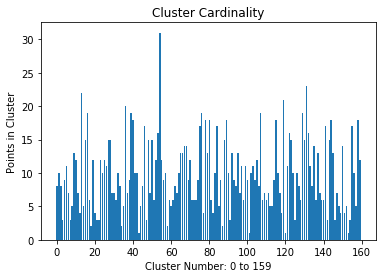

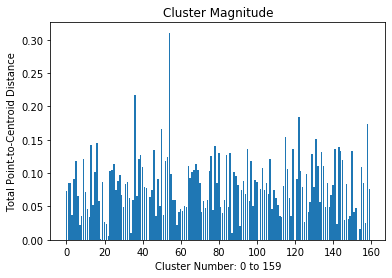

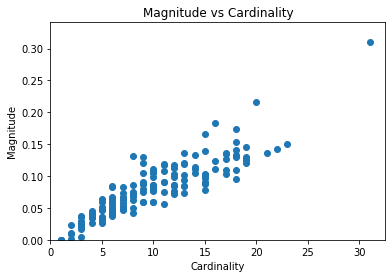

In [34]:
clusterQualityMetrics(choc_embed)

## Find Optimum Number of Clusters

Let's try finding the right number of clusters as you did in the previous programming exercise. For details, read "*Step Three: Optimum Number of Clusters*" on [Interpret Results](https://developers.google.com/machine-learning/clustering/interpret).

Run the code below (it takes a while!). The resulting plot is uneven for low `k`, showing that the k-means has a difficult time clustering the data. As `k` increases past 100, the loss evens out, showing that k-means is effectively grouping the data into clusters.

k-means converged for 5 clusters after 49 iterations!
k-means converged for 15 clusters after 48 iterations!
k-means converged for 25 clusters after 42 iterations!
k-means converged for 35 clusters after 32 iterations!
k-means converged for 45 clusters after 22 iterations!
k-means converged for 55 clusters after 16 iterations!
k-means converged for 65 clusters after 18 iterations!
k-means converged for 75 clusters after 14 iterations!
k-means converged for 85 clusters after 21 iterations!
k-means converged for 95 clusters after 14 iterations!
k-means converged for 105 clusters after 22 iterations!
k-means converged for 115 clusters after 13 iterations!
k-means converged for 125 clusters after 15 iterations!
k-means converged for 135 clusters after 16 iterations!
k-means converged for 145 clusters after 13 iterations!
k-means converged for 155 clusters after 16 iterations!
k-means converged for 165 clusters after 16 iterations!
k-means converged for 175 clusters after 15 iterations!
k-m

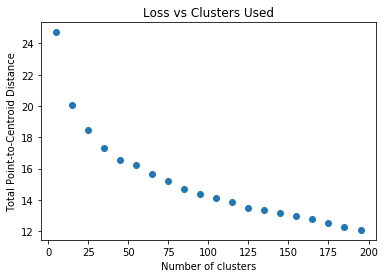

In [35]:
# Plot loss vs number of clusters
def lossVsClusters(kmin, kmax, kstep, choc_data):
  kmax += 1  # include kmax-th cluster in range
  kRange = range(kmin, kmax, kstep)
  loss = np.zeros(len(kRange))
  lossCtr = 0
  for kk in kRange:
    [choc_data, centroids] = kmeans(choc_data, kk, feature_cols, 0)
    loss[lossCtr] = np.sum(choc_data['pt2centroid'])
    lossCtr += 1
  plt.scatter(kRange, loss)
  plt.title('Loss vs Clusters Used')
  plt.xlabel('Number of clusters')
  plt.ylabel('Total Point-to-Centroid Distance')


kmin = 5  # @param
kmax = 200  # @param
kstep = 10  # @param
lossVsClusters(kmin, kmax, kstep, choc_embed)

# Summary

The codelab demonstrates these characteristics of a supervised similarity measure, described on the page [Supervised Similarity Measure](https://developers.google.com/machine-learning/clustering/similarity/supervised-similarity) in the table "*Comparison of Manual and Supervised Measures*":

* **Eliminates redundant information in correlated features**. As discussed in this [section](#scrollTo=MJtuP9w5jJHq), the DNN eliminates redundant information. However, to prove this characteristic, you'd need to train the DNN on adequate data and then compare with the results of a manual similarity measure.
* **Does not provides insight into calculated similarities**. Because you do not know what the embeddings represent, you have no insight into the clustering result.
* **Suitable for large datasets with complex features**. Our dataset was too small to adequately train the DNN, demonstrating that DNNs need large datasets to train. The advantage is that you do not need to understand the input data. Since large datasets are not easy to understand, these two characteristics go hand-in-hand.
* **Not suitable for small datasets**. A small dataset does not have enough information to train the DNN.